# Equation de Poisson

Au cours de ce TP, on cherche à résoudre l'équation de Poisson :

$$ \frac{\partial^2}{\partial x^2}u(x,y)+\frac{\partial^2}{\partial y^2}u(x,y)=f(x,y) $$
 
avec $f$ une fonction source.

Pour cela, on résoud par la méthode des différences finies, en définissant un maillage de l'espace. On limite ce maillage à une portion du plan $xy$. On limite le plan entre $0$ et $I$ selon $x$ et entre $0$ et $J$ selon $y$. 
$$
\left\{
    \begin{array}{ll}
        x_{i}=x_{0}+i\Delta x \quad 0 \leq x < I
        \\
        y_{i}=y_{0}+j\Delta x \quad 0 \leq x < J
    \end{array}
\right.
$$

Dans notre cas, nous allons nous intérésser à une fonction de Poisson en particulier : celle d'un potentiel électrostatique en présence de charge.

$$  \frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=\frac{\rho (x,y)}{\epsilon_{0}} $$

$\rho$ = densité volumique de charges

$\epsilon_{0}$ = permitivité relative du vide 

On choisit $I=J=1$ et on fait un maillage à 65 points.

In [25]:
#Import des bibliothèques utiles
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import scipy.sparse as sp                 
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp

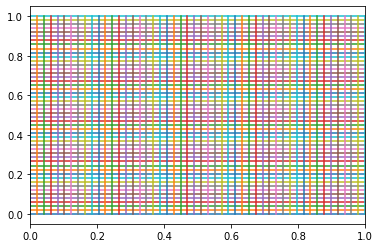

In [26]:
# Maillage de l'espace
I = 50
J = 50                       
x = np.linspace(0,1,I)     #division de l'espace selon x
y = np.linspace(0,1,J)        

dx = x[1] - x[0]                #pas selon x
dy = y[1] - y[0]                #pas selon y

X,Y = np.meshgrid(x,y)       #création de la matrice de maillage   

plt.plot(X) # tracé du maillage
plt.plot(X,Y)
plt.xlim([0,1])
plt.show()

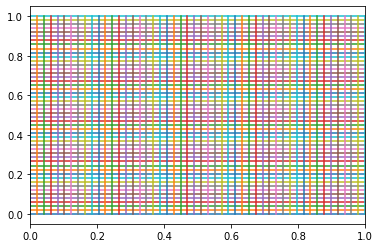
<h3 align="center">Maillage de l'espace</h3> 

### Développement de Taylor de l'équation
On développe à l'ordre 2, l'équation de Poisson : 

$$
\left\{
    \begin{array}{ll}
        \frac{\partial^2 u}{\partial x^2} \approx \frac{u(x+\Delta x, y)+u(x-\Delta x, y)-2u(x,y)}{\Delta x^2}
        \\
         \frac{\partial^2 u}{\partial y^2} \approx \frac{u(x, y+\Delta y)+u(x, y-\Delta y)-2u(x,y)}{\Delta y^2}
    \end{array}
\right.
$$

En notation discrète l'équation devient :

$$\frac{1}{\Delta x^2}(u_{i+1,j}+u_{i-1,j}-2u_{i,j})+\frac{1}{\Delta y^2}(u_{i,j+1}+u_{i,j-1}-2u_{i,j})=\rho_{i,j} $$

On réindèxe la matrice pour avoir une matrice $1D$

$$
\left\{
    \begin{array}{ll}
        0 \leq x < I
        \\
        0 \leq x < J
    \end{array}
\right.$$

$$
\Longrightarrow k=iJ+j,\; 0 \leq k\leq IJ
$$

On a alors une nouvelle fomulation de l'équation de Poisson :
$$\frac{1}{\Delta x^2}(u_{k+J+1}+u_{k-J-1})+\frac{1}{\Delta y^2}(u_{k+1}+u_{k-1})-2(\frac{1}{\Delta x^2}+\frac{1}{\Delta y^2})u_{k}=\rho_{k} $$

In [27]:
# On définit les éléments nécessaires à la construction du systême matriciel

#Création de la matrice système par la méthode classique des éléments finis on créé une matrice de taille (I*I,J*J) pour qu'il fit avec le vecteur b source
def A_sys(n,dx):
    h = dx #le pas
    A = np.zeros((n*n, n*n), dtype=float) #Construction de la matrice système d'équations 
    for i in range(n*n):
        A[i, i] = -4 #ne marche que si le pas est le même dans le sens des x et y (a voir dans la formule de Taylor)
    for i in range(n):
        for j in range(n-1):
            A[n*i+j, n*i+j+1] = 1 #coefficient à voir avec la formule de Taylor du pdf
            A[n*i+j+1, n*i+j] = 1
    for i in range(n-1):
        for j in range(n):
            A[n*(i+1)+j, n*i+j] = 1
            A[n*i+j, n*(i+1)+j] = 1
    return(A)
    

def Diff_mat_1D(I):
    
    # On dérive une première fois
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (I,I)) 
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]              
    D_1d[I-1,[I-3, I-2, I-1]] = [1, -4, 3]  
    
    
    
    # On dérive une deuxième fois
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (I, I))
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    
    D2_1d[I-1,[I-4, I-3, I-2, I-1]] = [-1, 4, -5, 2]  
    return D_1d, D2_1d


def Diff_mat_2D(I,J):
    Dx_1d, D2x_1d = Diff_mat_1D(I)
    Dy_1d, D2y_1d = Diff_mat_1D(J)

    # Matrices identité
    Ix = sp.eye(I)
    Iy = sp.eye(J)

    # Première dérivé partielle
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    
    # Seconde dérivé partielle
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()

# Réindexation 2D à 1D
Xu = X.ravel()                  # Créer l'array des abscisses 1D
Yu = Y.ravel()

# Construction du systême matriciel
Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(I,J)  
I_sp = sp.eye(I*J).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # systeme matriciel sans les conditions aux limites

### Conditions aux limites

Pour résoudre l'équation, on introduit des conditions aux limites. Dans notre cas, on impose des conditions de Dirichlet. La solution est nulle en dehors du domaine.

- Sur le côté gauche ($i=0$):

$$\frac{1}{\Delta x^2}(u_{1,j}-2u_{0,j})+\frac{1}{\Delta y^2}(u_{0,j+1}+u_{0,j-1}-2u_{0,j})=\rho_{0,j} $$

- Sur le côté droit ($i=I-1$):

$$\frac{1}{\Delta x^2}(u_{I-2,j}-2u_{I-1,j})+\frac{1}{\Delta y^2}(u_{I-1,j+1}+u_{I-1,j-1}-2u_{iI-1j})=\rho_{I-1,j} $$

- De même en bas ($j=0$) et en haut ($j=J-1$)

Ici, on choisit d'imposer les conditions de Dirichlet pour fixer les conditions au bord. On aurait pu imposer les conditions de Neumann, mais celles-ci sont généralement imposées lorsque l'on a des situations avec des conditions de bords dites "infinis" ce qui n'est pas le cas dans l'exemple ici

In [28]:
# Conditions de Dirichlet sur les bords du maillage
uL = 0
uR = 0
uT = 0
uB = 0

# Indices des bords pour construire la boite avec les conditions de Dirichlet

ind_bord_gauche = np.squeeze(np.where(Xu==x[0]))  # renvoie l'indice des bords à gauche de la boite 
ind_bord_droit = np.squeeze(np.where(Xu==x[I-1]))       
ind_bord_bas = np.squeeze(np.where(Yu==y[0]))         
ind_bord_haut = np.squeeze(np.where(Yu==y[J-1]))  

# Indices du maillages
ind_bords_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[I-1]) | (Yu==y[0]) | (Yu==y[J-1])))  # tous les bords en indice listé 
ind_bords = np.where((X==x[0]) | (X==x[I-1]) | (Y==y[0]) | (Y==y[J-1]))    # tous les bords en indice réel

### Lignes de charge

La densité volumique de charges dépend des coordonées. On a :

- Une ligne de charge positive pour $y=0.4$ et $0.25 \leq x \leq 0.75$
- Une ligne de charge négative pour $y=0.6$ et $0.25 \leq x \leq 0.75$

In [29]:
#Création de la matrice source
g = np.zeros(I*J) 

#densité volumique de charges
eo = 8.85e-12
upos = 1/eo
uneg = -1/eo

#Création du condensateur
 
xlimite = [0.25, 0.75]        # on limite la zone de x 
k = np.floor(0.4/dy)          #ce sont les lignes qui correspondent aux lignes dans le maillage ou on a y  = 0.4 et y = 0.6
k1 = np.floor(0.6/dy)
yupos = k*dy                 
yuneg = k1*dy                 

#ligne positive
list_charge_pos = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yupos)))  # renvoie l'indice des lignes ou il y a les charges positives
list_charge_pos_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yupos))    # renvoie l'indice des lignes ou il y a les charges positives sur la vrai matrice
#ligne négative
list_charge_neg = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yuneg)))  # renvoie l'indice des lignes ou il y a les charges négatives
list_charge_neg_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yuneg))    

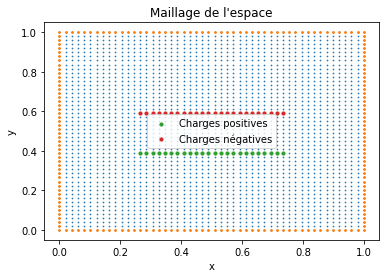

In [30]:
# On veut afficher les maillage, avec les conditions aux bords et termes sources

def my_contourf(x,y,F,ttl):
    py.contourf(x,y,F,41,cmap = 'inferno')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0

plt.scatter(X,Y,2,marker = '.') # création de l'espace maillé
plt.scatter(X[ind_bords],Y[ind_bords],3) # création des bords
plt.scatter(X[list_charge_pos_reel],Y[list_charge_pos_reel],10, label = 'Charges positives')
plt.scatter(X[list_charge_neg_reel],Y[list_charge_neg_reel],10,label = 'Charges négatives')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Maillage de l'espace")
plt.legend()

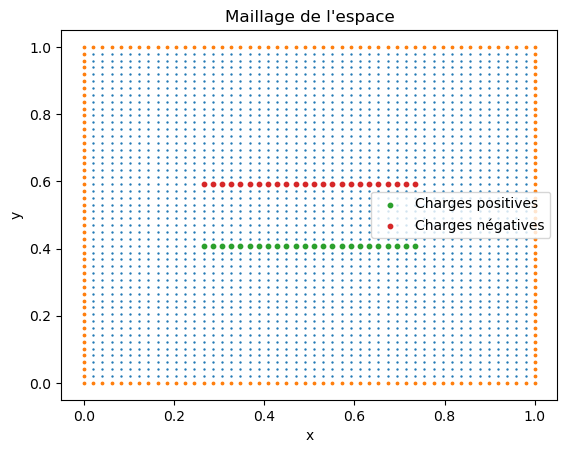

Ici, on voit qu'on a bien réalisé le maillage de l'espace, et qu'on a bien placé les charges positives et négatives et qu'on a fixé les conditions de Dirichlet sur les bords. La première phase d'initialisation est finie !

In [31]:
# Construction du vecteur source du système de Poisson
b = g
b[ind_bord_gauche] = uL # on rajoute les conditions sur les bords du maillage
b[ind_bord_droit] = uR
b[ind_bord_haut] = uT
b[ind_bord_bas] = uB

b[list_charge_pos] = upos # on rajoute les charges positives et négatives sur les lignes dans le vecteur b
b[list_charge_neg] = uneg

## Implémentation des méthodes de résolution de l'équation

On implémente différentes méthodes de résolution pour comparer leurs efficacités

In [32]:
# Implémentation du pivot de Gauss pour résoudre un systeme du type Ax = B, même si je n'y crois pas trop pour N = 65

def produit(A, B):
    return [[sum(L[k] * B[k][j] for k in range(len(L))) for j in range(len(B[0]))] for L in A]

def echange_lignes(M, i, j):
   M[i], M[j] = M[j], M[i]
   return M
   
def transvection_ligne(M, i, j, l):
    M[i] = [M[i][k] + l * M[j][k] for k in range(len(M[i]))]
    return M
   
def dilatation_ligne(M, i, l):
    M[i] = [coeff * l for coeff in M[i]]
    return M
   
def recherche_pivot_lignes(M, i):
    m = abs(M[i][i])
    j = i
    for k in range(i + 1, len(M)):
        if abs(M[i][j]) > m:
            j = k
    return j
   
def pivot_lignes(M):
   for i in range(len(M)):
        j = recherche_pivot_lignes(M, i)
        if j != i:
            echange_lignes(M, i, j)
        if M[i][i] != 0:
            for j in range(i + 1, len(M)):
                transvection_ligne(M, j, i, -M[j][i] / M[i][i])
   return M
   
def concatenation_vecteur(A, B):
    return [A[i] + [B[i]] for i in range(len(A))]

def pivot_lignes_rebours(M):
    for i in reversed(range(len(M))):
        dilatation_ligne(M, i, 1 / M[i][i])
        for j in range(i):
            transvection_ligne(M, j, i, -M[j][i])
    return M

def extract_vecteur(M):
    return [L[-1] for L in M]

def resolution(A, B):
    M = concatenation_vecteur(A, B)
    pivot_lignes(M)
    pivot_lignes_rebours(M)
    return extract_vecteur(M)

#par la méthode du pivot de gauss
def poisson_matrice_gauss(n, dx):
    A = A_sys(n,dx)
    v = -b
    return resolution(A, v).reshape((n, n))

In [33]:
# Méthode utilisant la méthode des différences finies avec np.linalg.solve pour résoudre le système 
def poisson_matrice_linalg(n, dx):
    A = A_sys(n,dx)
    v = -b # le vecteur source de l'équation de Poisson, on met un - devant b pour prendre en compte le -rho dans l'équation de Poisson 
    return np.linalg.solve(A, v).reshape((n, n))


Avec la méthode de sur relaxation, on décide d'implémenter directement la sur relaxation plutôt que de passer par Gauss Seidel. Si j'ai bien compris les maths derrière, on utilise des suites pour résoudre des systèmes linéaires de types Ax=b en écrivant A = D -E-F avec D une matrice diagonale, E une matrice triangulaire supérieur et F inférieur. On aboutit après calcul Ax = b à la formule donnée par le pdf du github en injectant le paramètre $\omega$ dans l'équation.
Je passe directement à la méthode de sur relaxation car la méthode de Gauss Seidel est la méthode de sur relaxation pour $\omega = 1$

In [34]:
def poisson_relax(A, b, w, eps, max_iterations):
    x = np.zeros_like(b, dtype=np.double)
    for k in range(max_iterations):
        x_old  = x.copy() #il faut bien faire gaffe à garder les anciennes valeurs avant actualisation sinon on va faire un mauvais calcul
        for i in range(A.shape[0]):
            x[i] = x[i]*(1-w) + (w/A[i,i])*(b[i] - np.matmul(A[i,:i], x[:i]) - np.matmul(A[i,(i+1):], x_old[(i+1):])) #formule du pdf
        LnormInf = max(abs((x - x_old)))/max(abs(x_old)) 
        if  LnormInf < eps: #on utilise ici un critère de convergence relatif qui va nous servir comme condition d'arrêt de la boucle d'itération par rapport à une précision souhaitée
            break    # je n'ai pas utilisé de while car ça ne marchait pas avec mon ordi la boucle tournait quasi infiniment donc j'ai mis un nombre max d'itérations
    return x

#### Calcul des dérivées partielles de l'équation de Poisson pour la méthode Sparse 

Dans un premier temps, on travaille sur une seule dimension et ensuite on l'étend en 2D au maillage. Ici comme on manipule des matrices pleines de 0, on utilise la méthode sparse qui consiste à remplir les matrices avec seulement les endroits ou l'élement est non nul. Attention, si il y a pas beaucoup de zero cette méthode est très longue car on remplit un par un la matrice mais dans notre cas on manipule des matrices creuses donc on peut utiliser cette méthode. 


In [35]:
def Derive1D(Nx):
    # Première dérivée
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # on doit diviser par le pas au carré 
    D_1d = sp.lil_matrix(D_1d)                  # Ici on crée la matrice de diag nul, la diag supérieur a celle centrale qui vaut que des 1 et celle d'en dessous qui vaut que des -1 
    D_1d[0,[0,1,2]] = [1, -4, 1]               # on créer la première dérivée en accord avec la formule de Taylor
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 1]  
    # Seconde dérivée
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [1, 1, -4, 1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [1, -4, 1, 1]  
    return D_1d, D2_1d


def Derive2D(Nx,Ny):
    Dx_1d, D2x_1d = Derive1D(Nx) #on récupère les premières dérivées 1D à la bonne dimension 
    Dy_1d, D2y_1d = Derive1D(Ny)
    # matrice identité sparse
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)
    # utilisation du produit de kronecker avec l'identité sparse pour la fabriquation de la matrice du système comprenant les deux dérivées partielles
    # Première dérivée partielle
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    # deuxième dérivée partielle
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()  #format de la sparse matrice

## Résolution et comparaison des méthodes

In [12]:
# Résolution de l'équation avec la méthode du pivot de Gauss

start2 = time.time()
u2 = poisson_matrice_gauss(I,dx)
end2 = time.time()
temps_gauss = end2-start2
plt.figure(3)
plt.contourf(x,y,u1,41,cmap ='cosmos')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode du pivot de Gauss")

print('Le temps pour la méthode du pivot de Gauss est',temps_gauss)

KeyboardInterrupt: 

Ici on se rends compte que le temps de calcul est beaucoup trop long. Le programme ne se termine pas, il est donc impossible à appliquer dans ces conditions.

Le temps pour la méthode sparse est 0.07552790641784668


0

<Figure size 432x288 with 0 Axes>

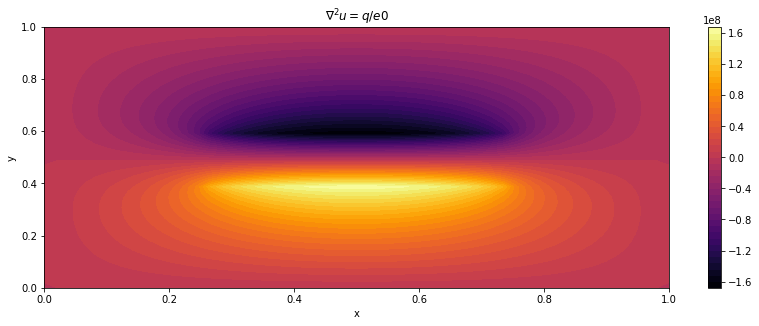

In [36]:
# Résolution de l'équation de Poisson avec la méthode sparse

start1 = time.time() #mesure du temps de résolution

Dx_2d, Dy_2d, D2x_2d, D2y_2d = Derive2D(I,J)  #on initialise les dérivées 2D secondes dans l'équation de Poisson
I_sp = sp.eye(I*J).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # on construit le système sans les conditions au limite avec les fonctions dérivées précédemment écrites

# On redéfinit le systême matriciel avec les conditions aux bords
L_sys[ind_bords_unravel,:] = I_sp[ind_bords_unravel,:] 

# Résolution de l'équation de Poisson avec la méthode sparse
u = spsolve(L_sys,-b).reshape(I,J) #on met -b car pour prendre en compte le -devant le rho dans l'équation de poisson et avoir les charges négatives en haut

end1 = time.time()
temps_sparse = end1-start1

print('Le temps pour la méthode sparse est',temps_sparse)

# Tracé de la solution
plt.figure(1)
py.figure(figsize = (14,4.8))
my_contourf(x,y,u,r'$\nabla^2 u = q/e0$')


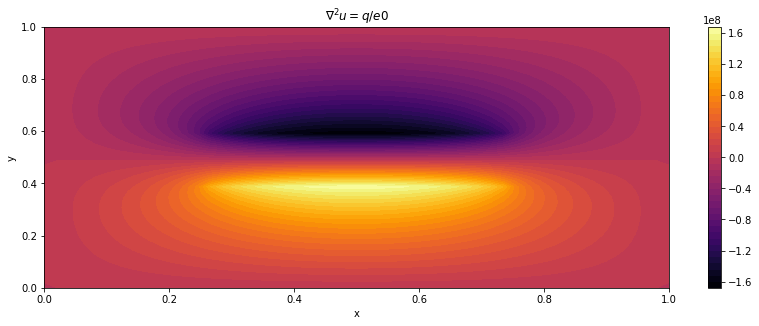
<h3 align="center">Résolution de l'équation de Poisson avec la méthode Sparse de scipy</h3> 

On retrouve bel et bien ici la figure de potentiel d'un condensateur tel qu'on le connait. On a bien un potentiel négatif pour les charges négative en haut en y= 0.6 et un potentiel positif pour les charges positives en y = 0.4. On remarque également que le potentiel à l'intérieur des deux plaques n'est pas uniforme sur les bords, mais peut l'être considéré au centre. De plus, on retrouve les potentiels en sin(theta) à l'extérieur du condensateur pour chaque plaque, que l'on peut retrouver avce le champ E d'un condensateur. On a des résultats graphiques cohérents c'est encourageant !

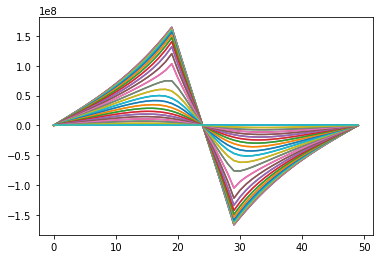

In [37]:
plt.plot(u)

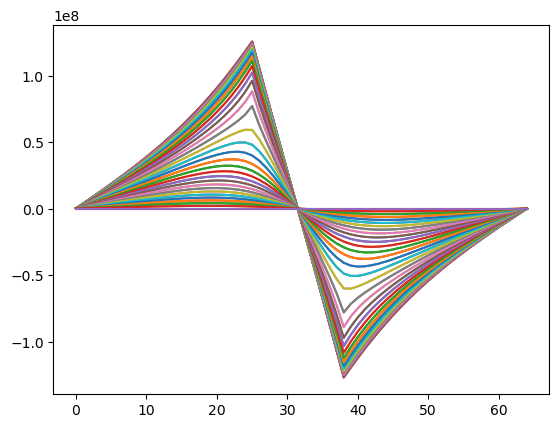

Nous avons bien le max de potentiel positif (des charges positives) pour chaque fonction en 25 qui correspond à la ligne 25 où sont plaçés les charges positives (resp. négatives pour la ligne 38)

Le temps pour la méthode linalg.solve est 0.41655516624450684


Text(0.5, 1.0, "Résolution de l'équation de Poisson avec la méthode linalg.solve de numpy")

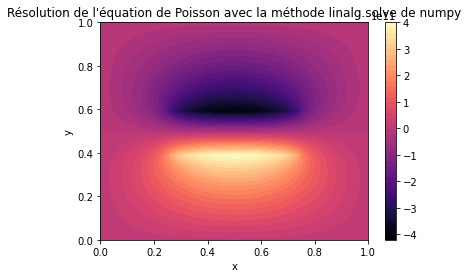

In [38]:
# Résolution de l'équation avec linalg.solve du module numpy 

start = time.time()
u1 = poisson_matrice_linalg(I,dx)
end = time.time()
temps_linalg = end-start
print('Le temps pour la méthode linalg.solve est',temps_linalg)

#tracé graphique
plt.figure(2)
plt.contourf(x,y,u1,41,cmap ='magma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode linalg.solve de numpy")

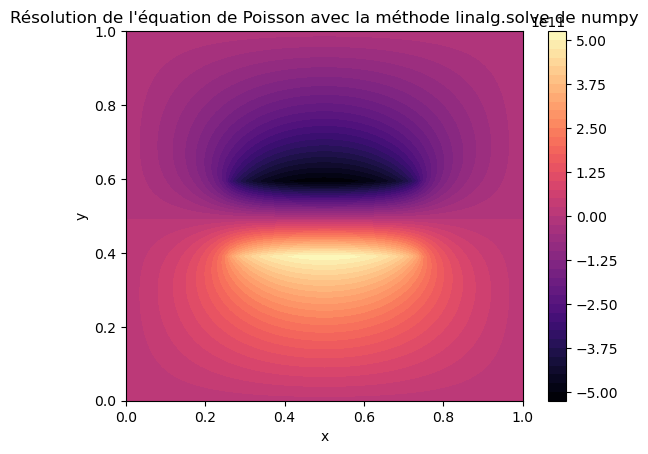

In [39]:
# Résolution de l'équation avec la méthode de sur-relaxation
A = A_sys(I,dx)
omega_opti = 2 / (1 + np.sin(np.pi * dx)) #w optimal pour l'équation de Poisson avec des conditions de Dirichlet, w=1 pour Gauss-Seidel
eps = 1e-7
max_iteration = 1000

start3 = time.time()
u = poisson_relax(A,-b,omega_opti,eps,max_iteration)
u4 = u.reshape(65,65)
end3 = time.time()
temps_relaxation = end3-start3
plt.figure(2)
plt.contourf(x,y,u4,41,cmap ='magma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode de sur relaxation")

<ipython-input-34-0538a980d1d5>:7: RuntimeWarning: divide by zero encountered in double_scalars
  LnormInf = max(abs((x - x_old)))/max(abs(x_old))


ValueError: cannot reshape array of size 2500 into shape (65,65)

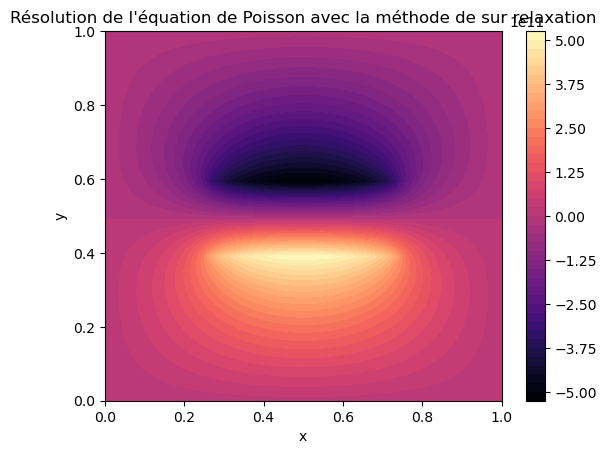

In [24]:
# Affichage du résultat
print('Le temps pour la méthode sparse est',temps_sparse)
print('Le temps pour la méthode linalg.solve est',temps_linalg)
print('Le temps pour la méthode sur relaxation est',temps_relaxation)
print('Le temps de calcul le plus court est',min(temps_sparse,temps_linalg,temps_relaxation))

Le temps pour la méthode sparse est 0.056138038635253906
Le temps pour la méthode linalg.solve est 0.3469557762145996


NameError: name 'temps_relaxation' is not defined

Le temps pour la méthode sparse est 0.0249178409576416
\
Le temps pour la méthode linalg.solve est 0.36421847343444824
\
Le temps pour la méthode sur relaxation est 5.2224342823028564

Le temps de calcul le plus court est 0.0249178409576416

On se rends compte ici que l'utilisation de matrices Sparse est ici un choix judicieux car on travaille avec des matrices quasi creuses qui sont adaptées au problème de l'équation de Poisson (source seulement réparti dans un petit coin de l'espace). Cette méthode est quasi 10 fois plus performante que l'utilisation classique de la résolution par linalg.solve et bien plus que la relaxation, même je ne pense pas avoir utilisé les paramètres les plus optimisés pour la relaxation. Je ne parle même pas de la méthode de Gauss qui est juste impossible à utiliser avec du N =65 (à part sur un supercalculateur...)

On obtient des résultats qui correspondent bien aux lignes de courant que l'on connaît bien d'un condensateur néanmoins il y a quelque chose que je n'arrive pas à expliquer, c'est la différence entre les valeurs obtenues analytiquement avec la méthode Sparse et celle avec np.linalg.solve et la relaxation. J'ai regardé comment la fonction linalg.solve était construite mais je n'ai pas compris d'où venait cette différence. Cependant, la méthode de relaxation donne les mêmes valeurs donc je me suis peut être trompé dans la méthode sparse en construisant la matrice sparse (erreur de coefficient éventuellement?).

Par ailleurs, les valeurs en ordre de grandeur du potentiel ne sont pas bonnes car on a pris e = 1 pour simplifier les calculs.

En Conclusion, nous proposons la méthode Sparse pour résoudre ce problème car elle semble plus simple et plus efficace, et plus juste au niveau du graphique car au centre on ne voit pas vraiment le caractère uniforme du champ pour les méthodes linalg et relaxation alors que c'est bien le cas pour la méthode sparse, même si cette méthode renvoie des valeurs différentes des deux autres méthodes. On supposera que cela vient éventuellement d'une erreur dans les coefficients des matrices mais nous n'avons pas su identifier l'erreur.